In [28]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from numpy import recarray

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torchvision import transforms
import torch.utils.data as data
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import os
import copy
import platform
import secrets

if torch.cuda.is_available():
    device = 'cuda'
    print('on cuda')
elif torch.backends.mps.is_available():
    device = 'mps'
    print('on mps')
else:
    device = 'cpu'
    print('on cpu')

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

on cuda


In [7]:
class mHealth(data.Dataset):

    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): dataframe containing data
        """
        self.dataset = dataframe

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index
        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 in (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        sequence = torch.tensor(self.dataset[index:index+128].to_numpy()).type(torch.float32) 
        sequence = sequence.unsqueeze(dim=1) #remove when using 3 dim, currently needed for 1 dim data
        
        return sequence

#pad sequences that aren't 128 length with 0's
def collate_fn(data):
    inputs = [torch.tensor(d) for d in data]

    inputs = pad_sequence(inputs, batch_first=True)

    return inputs

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        
        self.fc = nn.Linear(num_layers, 1)

    def forward(self, x):
        
        outputs, (hidden, cell) = self.lstm(x.to(device))
        
        return outputs, (hidden, cell)


class Decoder(nn.Module):
    def __init__(
        self, input_size=1, hidden_size=64, output_size=1, num_layers=1):
        
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        print("decoder layers: ", self.num_layers)
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size
        )

    def forward(self, x, hidden):
        
        hidden = (hidden[0], hidden[1])
        output, (hidden, cell) = self.lstm(x, hidden)
        prediction = self.fc(output)
        
        return prediction, (hidden, cell)


class LSTMVAE(nn.Module):
    """LSTM-based Variational Auto Encoder"""

    def __init__(
        self, input_size, hidden_size, latent_size, seq_len, num_layers, device
    ):
        """
        input_size: int, number of input features, default=3
        hidden_size: int, size of hidden layer, default=256
        latent_size: int, latent z-layer size, default=128
        seq_size: int, sequence length of input
        num_layers: int, number of layers in LSTM, default=2
        """
        super(LSTMVAE, self).__init__()
        self.device = device

        # init
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.seq_len = seq_len
        self.num_layers = num_layers

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers
        )

        self.lstm_dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
        )


        self.fc21 = nn.Linear(self.hidden_size, self.latent_size) #expected input: [64, 0]
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)
        self.fc_fix = nn.Linear(self.seq_len * self.num_layers, self.seq_len)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.shape

        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        h_ = self.fc3(z)

        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len * self.num_layers, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()
        
        x_hat = self.fc_fix(x_hat)

        losses = self.loss_function(x_hat, x, mean, logvar)
        m_loss, recon_loss, kld_loss = (
            losses["loss"],
            losses["Reconstruction_Loss"],
            losses["KLD"],
        )

        return m_loss, x_hat, (recon_loss, kld_loss)
    
    def encode(self, x):
        batch_size, seq_len, feature_dim = x.shape
        
        outputs, enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        
        return z
    
    def decode(self, z):
        batch_size, seq_len, feature_dim = z.shape
        
        h_ = self.fc3(z)
        
        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len * self.num_layers, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()
        
        x_hat = self.fc_fix(x_hat)
        
        return x_hat
    
    def reconstruct(self, x):
        # print("reconstruct x shape: ", x.shape)
        batch_size, seq_len, feature_dim = x.shape
        

        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        latent = z
        h_ = self.fc3(z)

        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len * self.num_layers, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()
        
        x_hat = self.fc_fix(x_hat)
        
        # print("x hat shape: ", x_hat.shape)

        return latent, x_hat

    def loss_function(self, *args, **kwargs) -> dict:
        """
        
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0].to(device).unsqueeze(dim=2)
        input = args[1].to(device)
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.00025  # Account for the minibatch samples from the dataset

        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }

0        -9.8184
1        -9.8489
2        -9.6602
3        -9.6507
4        -9.7030
           ...  
161275   -9.4032
161276   -9.5201
161277   -9.3682
161278   -8.6702
161279   -8.7211
Name: chest acceleration X-axis, Length: 161280, dtype: float64

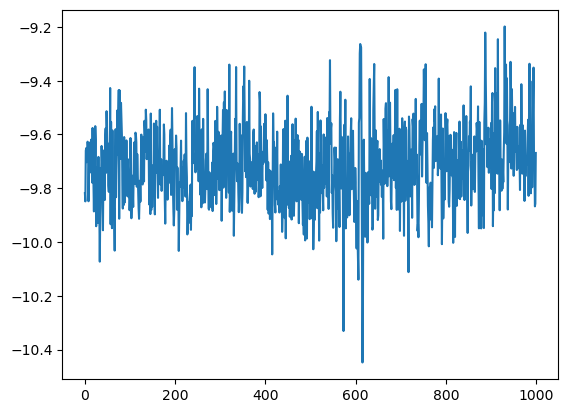

In [9]:
if(platform.system() == 'Darwin'):
    print('hi')

dataset_path = os.getcwd() + '/processed_data/mHealth_subject1.csv'

dataset = pd.read_csv(dataset_path)
dataset = dataset['chest acceleration X-axis'] #drop all columns that aren't chest accel info
plt.plot(dataset[:1000])

dataset

In [10]:
LOAD_MODEL = False
split_idx = int(len(dataset) * 0.8)

# training dataset
train_set = mHealth(
    dataframe=dataset[:split_idx],
)

test_set = mHealth(
    dataframe=dataset[split_idx:],
)

batch_size = 128
input_size = 1
hidden_size = 256
latent_size = 128
sequence_len = 128
num_layers = 2
clip_value = 5

# define LSTM-based VAE model
if(LOAD_MODEL):
    model = LSTMVAE(input_size, hidden_size, latent_size, sequence_len, num_layers, device=device)
    if(platform.system() == 'Darwin'):
        model.load_state_dict(torch.load('/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_4_layer_state_dict'))
    elif(platform.system() == 'Windows'):
        model.load_state_dict(torch.load('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\VAE+RNN\\lstm_vae\\state_dicts\\aug_3_2_layers'))
    else:
        model.load_state_dict(torch.load('/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_4_layer_state_dict'))
        print("linux")
    print("model loaded from state dict | system: ", platform.system())
else:
    model = LSTMVAE(input_size, hidden_size, latent_size, sequence_len, num_layers, device=device)

model.to(device)
print("training on: ", device)
print('----------------------------------------------------------------\n', 
      model)

decoder layers:  2
training on:  cuda
----------------------------------------------------------------
 LSTMVAE(
  (lstm_enc): Encoder(
    (lstm): LSTM(1, 256, num_layers=2, batch_first=True)
    (fc): Linear(in_features=2, out_features=1, bias=True)
  )
  (lstm_dec): Decoder(
    (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc21): Linear(in_features=256, out_features=128, bias=True)
  (fc22): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc_fix): Linear(in_features=256, out_features=128, bias=True)
)


In [11]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

print(f"Dataloaders: {train_loader}")
print(f"Length of train_dataloader: {len(train_loader)} batches of {batch_size}")


for idx, data in enumerate(train_loader):
    datas = data
    print("datas shape: ", datas.shape)
    break

train_loss = []
test_loss = []
learning_rate = []

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x0000025307B58690>
Length of train_dataloader: 1008 batches of 128
datas shape:  torch.Size([128, 128, 1])


C:\Users\Admin\AppData\Local\Temp\ipykernel_35552\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [12]:
def train(iterations, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

    ## interation setup
    epochs = tqdm(range(iterations // len(train_loader)))

    ## training
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(
            enumerate(train_loader), total=len(train_loader)-32, desc="training"
        )
        
        temp = -1
        
        for i, batch_data in train_iterator:

            if count > iterations:
                return model
            count += 1

            past_data = batch_data

            mloss, recon_x, recon_loss = model(past_data)

            # Backward and optimize
            optimizer.zero_grad()
            mloss.mean().backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            optimizer.step()

            train_iterator.set_postfix({"train_loss": float(mloss.mean())})
            temp = float(mloss.mean())
            
        if(temp != -1):
            train_loss.append(temp)
            
        before_lr = optimizer.param_groups[0]["lr"]
        learning_rate.append(float(before_lr))
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(
            enumerate(test_loader), total=len(test_loader), desc="testing"
        )

        with torch.no_grad():
            for i, batch_data in test_iterator:
                past_data = batch_data

                ## reshape
                batch_size = past_data.size(0)
                example_size = past_data.size(1)
                past_data = (
                    past_data.view(batch_size, example_size, -1).float().to(device)
                )

                mloss, recon_x, info = model(past_data)

                eval_loss += mloss.mean().item()

                test_iterator.set_postfix({"test_loss": float(mloss.mean())})
                temp = float(mloss.mean())
            
        if(temp != -1):
            test_loss.append(temp)
        eval_loss = eval_loss / len(test_loader)
        print("Evaluation Score : [{}]".format(eval_loss))
        torch.cuda.empty_cache()

    return model


In [43]:
iterations = 200000 ## iterations = total iterations, epochs = iterations / len(dataloader)
train(iterations, model, train_loader, test_loader)

  0%|          | 0/198 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_35552\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]
training: 1008it [01:11, 14.15it/s, train_loss=4.54]


Epoch 0: SGD lr 0.0010 -> 0.0010


  1%|          | 1/198 [01:18<4:17:38, 78.47s/it]

Evaluation Score : [1.9518002219912078]


training: 1008it [01:09, 14.54it/s, train_loss=4.96]


Epoch 1: SGD lr 0.0010 -> 0.0010


  1%|          | 2/198 [02:34<4:12:21, 77.25s/it]

Evaluation Score : [2.23645656851549]


training: 1008it [01:12, 13.97it/s, train_loss=5.24]


Epoch 2: SGD lr 0.0010 -> 0.0010


  2%|▏         | 3/198 [03:54<4:13:56, 78.13s/it]

Evaluation Score : [2.236780127140856]


training: 1008it [01:09, 14.58it/s, train_loss=5.05]


Epoch 3: SGD lr 0.0010 -> 0.0010


  2%|▏         | 4/198 [05:10<4:10:10, 77.37s/it]

Evaluation Score : [2.2354074794769523]


training: 1008it [01:09, 14.56it/s, train_loss=4.9]


Epoch 4: SGD lr 0.0010 -> 0.0010


  3%|▎         | 5/198 [06:26<4:08:01, 77.11s/it]

Evaluation Score : [2.055215834994756]


training: 1008it [01:13, 13.73it/s, train_loss=5.26]


Epoch 5: SGD lr 0.0010 -> 0.0010


  3%|▎         | 6/198 [07:47<4:10:54, 78.41s/it]

Evaluation Score : [2.335381364804648]


training: 1008it [01:11, 14.13it/s, train_loss=4.66]


Epoch 6: SGD lr 0.0010 -> 0.0010


  4%|▎         | 7/198 [09:06<4:09:35, 78.40s/it]

Evaluation Score : [2.234969002416446]


training: 1008it [01:10, 14.29it/s, train_loss=4.69]


Epoch 7: SGD lr 0.0010 -> 0.0010


  4%|▍         | 8/198 [10:23<4:07:23, 78.12s/it]

Evaluation Score : [2.4074948583064333]


training: 1008it [01:11, 14.04it/s, train_loss=6.19]


Epoch 8: SGD lr 0.0010 -> 0.0010


  5%|▍         | 9/198 [11:42<4:06:50, 78.36s/it]

Evaluation Score : [2.115852685689571]


training: 1008it [01:11, 14.11it/s, train_loss=4.67]


Epoch 9: SGD lr 0.0010 -> 0.0010


  5%|▌         | 10/198 [13:01<4:05:37, 78.39s/it]

Evaluation Score : [2.188700278038307]


training: 1008it [01:11, 14.12it/s, train_loss=4.62]


Epoch 10: SGD lr 0.0010 -> 0.0010


  6%|▌         | 11/198 [14:19<4:04:44, 78.53s/it]

Evaluation Score : [2.0347034178881183]


training: 1008it [01:11, 14.05it/s, train_loss=4.62]


Epoch 11: SGD lr 0.0010 -> 0.0010


  6%|▌         | 12/198 [15:38<4:03:43, 78.62s/it]

Evaluation Score : [1.8995076000749591]


training: 1008it [01:10, 14.30it/s, train_loss=4.72]


Epoch 12: SGD lr 0.0010 -> 0.0010


  7%|▋         | 13/198 [16:56<4:01:37, 78.36s/it]

Evaluation Score : [2.057296370170892]


training: 1008it [01:12, 13.95it/s, train_loss=5.06]


Epoch 13: SGD lr 0.0010 -> 0.0010


  7%|▋         | 14/198 [18:16<4:01:31, 78.76s/it]

Evaluation Score : [1.8904432565683411]


training: 1008it [01:09, 14.42it/s, train_loss=4.66]


Epoch 14: SGD lr 0.0010 -> 0.0010


  8%|▊         | 15/198 [19:33<3:58:32, 78.21s/it]

Evaluation Score : [2.0185121303453806]


training: 1008it [01:10, 14.28it/s, train_loss=5.11]


Epoch 15: SGD lr 0.0010 -> 0.0010


  8%|▊         | 16/198 [20:50<3:56:35, 78.00s/it]

Evaluation Score : [2.261715641053068]


training: 1008it [01:10, 14.40it/s, train_loss=5.15]


Epoch 16: SGD lr 0.0010 -> 0.0010


  9%|▊         | 17/198 [22:07<3:54:32, 77.75s/it]

Evaluation Score : [1.9923101286625577]


training: 1008it [01:09, 14.50it/s, train_loss=4.71]


Epoch 17: SGD lr 0.0010 -> 0.0010


  9%|▉         | 18/198 [23:24<3:52:02, 77.35s/it]

Evaluation Score : [1.9702854521040405]


training: 1008it [01:10, 14.32it/s, train_loss=4.94]


Epoch 18: SGD lr 0.0010 -> 0.0010


 10%|▉         | 19/198 [24:41<3:51:02, 77.45s/it]

Evaluation Score : [2.210710211509159]


training: 1008it [01:10, 14.29it/s, train_loss=4.69]


Epoch 19: SGD lr 0.0010 -> 0.0010


 10%|█         | 20/198 [25:59<3:50:04, 77.55s/it]

Evaluation Score : [2.234463874457611]


training: 1008it [01:10, 14.35it/s, train_loss=5.06]


Epoch 20: SGD lr 0.0010 -> 0.0010


 11%|█         | 21/198 [27:17<3:48:40, 77.52s/it]

Evaluation Score : [1.9498854701422037]


training: 1008it [01:09, 14.46it/s, train_loss=4.56]


Epoch 21: SGD lr 0.0010 -> 0.0010


 11%|█         | 22/198 [28:34<3:46:49, 77.33s/it]

Evaluation Score : [2.174466496067388]


training: 1008it [01:09, 14.42it/s, train_loss=4.65]


Epoch 22: SGD lr 0.0010 -> 0.0010


 12%|█▏        | 23/198 [29:50<3:45:12, 77.21s/it]

Evaluation Score : [2.0686460325405713]


training: 1008it [01:09, 14.43it/s, train_loss=4.88]


Epoch 23: SGD lr 0.0010 -> 0.0010


 12%|█▏        | 24/198 [31:07<3:43:33, 77.09s/it]

Evaluation Score : [2.023893794074418]


training: 1008it [01:04, 15.58it/s, train_loss=4.59]


Epoch 24: SGD lr 0.0010 -> 0.0010


 13%|█▎        | 25/198 [32:18<3:37:08, 75.31s/it]

Evaluation Score : [2.023960103443454]


training: 1008it [01:10, 14.26it/s, train_loss=4.94]


Epoch 25: SGD lr 0.0010 -> 0.0010


 13%|█▎        | 26/198 [33:36<3:37:56, 76.03s/it]

Evaluation Score : [1.9912798705525578]


training: 1008it [01:08, 14.71it/s, train_loss=4.51]


Epoch 26: SGD lr 0.0010 -> 0.0010


 14%|█▎        | 27/198 [34:52<3:36:16, 75.88s/it]

Evaluation Score : [2.1049639646348264]


training: 1008it [01:09, 14.57it/s, train_loss=4.9]


Epoch 27: SGD lr 0.0010 -> 0.0010


 14%|█▍        | 28/198 [36:08<3:35:13, 75.96s/it]

Evaluation Score : [2.3198435485717797]


training: 1008it [01:07, 14.99it/s, train_loss=6.6]


Epoch 28: SGD lr 0.0010 -> 0.0010


 15%|█▍        | 29/198 [37:22<3:32:42, 75.52s/it]

Evaluation Score : [1.9206445866101791]


training: 1008it [01:09, 14.56it/s, train_loss=4.51]


Epoch 29: SGD lr 0.0010 -> 0.0010


 15%|█▌        | 30/198 [38:38<3:32:00, 75.72s/it]

Evaluation Score : [1.8236772622469635]


training: 1008it [01:09, 14.47it/s, train_loss=5.14]


Epoch 30: SGD lr 0.0010 -> 0.0010


 16%|█▌        | 31/198 [39:55<3:31:28, 75.98s/it]

Evaluation Score : [1.8984854880365587]


training: 1008it [01:11, 14.01it/s, train_loss=4.59]


Epoch 31: SGD lr 0.0010 -> 0.0010


 16%|█▌        | 32/198 [41:14<3:33:02, 77.00s/it]

Evaluation Score : [1.869493339151617]


training: 1008it [01:11, 14.08it/s, train_loss=4.73]


Epoch 32: SGD lr 0.0010 -> 0.0010


 17%|█▋        | 33/198 [42:34<3:33:30, 77.64s/it]

Evaluation Score : [1.807472353564605]


training: 1008it [01:09, 14.60it/s, train_loss=4.79]


Epoch 33: SGD lr 0.0010 -> 0.0010


 17%|█▋        | 34/198 [43:49<3:30:47, 77.12s/it]

Evaluation Score : [1.8426235177598538]


training: 1008it [01:08, 14.75it/s, train_loss=4.65]


Epoch 34: SGD lr 0.0010 -> 0.0010


 18%|█▊        | 35/198 [45:05<3:27:59, 76.56s/it]

Evaluation Score : [1.7860074224216598]


training: 1008it [01:10, 14.35it/s, train_loss=5.02]


Epoch 35: SGD lr 0.0010 -> 0.0010


 18%|█▊        | 36/198 [46:23<3:27:43, 76.94s/it]

Evaluation Score : [1.9005503168418294]


training: 1008it [01:10, 14.36it/s, train_loss=4.52]


Epoch 36: SGD lr 0.0010 -> 0.0010


 19%|█▊        | 37/198 [47:40<3:26:32, 76.97s/it]

Evaluation Score : [1.8472877685867606]


training: 1008it [01:08, 14.63it/s, train_loss=4.56]


Epoch 37: SGD lr 0.0010 -> 0.0010


 19%|█▉        | 38/198 [48:56<3:24:26, 76.67s/it]

Evaluation Score : [1.9368906870543483]


training: 1008it [01:08, 14.64it/s, train_loss=4.54]


Epoch 38: SGD lr 0.0010 -> 0.0010


 20%|█▉        | 39/198 [50:12<3:22:48, 76.53s/it]

Evaluation Score : [2.054933409221352]


training: 1008it [01:10, 14.21it/s, train_loss=5.5]


Epoch 39: SGD lr 0.0010 -> 0.0010


 20%|██        | 40/198 [51:30<3:22:41, 76.97s/it]

Evaluation Score : [2.0882834828207417]


training: 1008it [01:10, 14.33it/s, train_loss=4.63]


Epoch 40: SGD lr 0.0010 -> 0.0010


 21%|██        | 41/198 [52:47<3:21:45, 77.11s/it]

Evaluation Score : [2.1583389533713224]


training: 1008it [01:11, 14.12it/s, train_loss=5.62]


Epoch 41: SGD lr 0.0010 -> 0.0010


 21%|██        | 42/198 [54:06<3:21:35, 77.54s/it]

Evaluation Score : [1.8837619862770514]


training: 1008it [01:12, 13.85it/s, train_loss=5.55]


Epoch 42: SGD lr 0.0010 -> 0.0010


 22%|██▏       | 43/198 [55:26<3:22:08, 78.25s/it]

Evaluation Score : [1.8919020069556103]


training: 1008it [01:13, 13.72it/s, train_loss=5.09]


Epoch 43: SGD lr 0.0010 -> 0.0010


 22%|██▏       | 44/198 [56:46<3:22:40, 78.96s/it]

Evaluation Score : [1.9895651687143578]


training: 1008it [01:09, 14.55it/s, train_loss=4.55]


Epoch 44: SGD lr 0.0010 -> 0.0010


 23%|██▎       | 45/198 [58:03<3:19:15, 78.14s/it]

Evaluation Score : [1.9132210952008055]


training: 1008it [01:10, 14.34it/s, train_loss=5.02]


Epoch 45: SGD lr 0.0010 -> 0.0010


 23%|██▎       | 46/198 [59:20<3:17:14, 77.86s/it]

Evaluation Score : [1.9197704111861567]


training: 1008it [01:12, 13.89it/s, train_loss=4.55]


Epoch 46: SGD lr 0.0010 -> 0.0010


 24%|██▎       | 47/198 [1:00:39<3:17:11, 78.35s/it]

Evaluation Score : [2.035285389376065]


training: 1008it [01:09, 14.52it/s, train_loss=4.87]


Epoch 47: SGD lr 0.0010 -> 0.0010


 24%|██▍       | 48/198 [1:01:56<3:14:45, 77.90s/it]

Evaluation Score : [1.8961485376847642]


training: 1008it [01:12, 13.95it/s, train_loss=4.55]


Epoch 48: SGD lr 0.0010 -> 0.0010


 25%|██▍       | 49/198 [1:03:15<3:14:33, 78.35s/it]

Evaluation Score : [2.1549640133503885]


training: 1008it [01:08, 14.68it/s, train_loss=5.65]


Epoch 49: SGD lr 0.0010 -> 0.0010


 25%|██▌       | 50/198 [1:04:31<3:11:14, 77.53s/it]

Evaluation Score : [1.9567778987721318]


training: 1008it [01:08, 14.62it/s, train_loss=4.51]


Epoch 50: SGD lr 0.0010 -> 0.0010


 26%|██▌       | 51/198 [1:05:47<3:08:44, 77.04s/it]

Evaluation Score : [2.01509739795611]


training: 1008it [01:11, 14.08it/s, train_loss=4.67]


Epoch 51: SGD lr 0.0010 -> 0.0010


 26%|██▋       | 52/198 [1:07:06<3:08:34, 77.50s/it]

Evaluation Score : [2.0977819689239063]


training: 1008it [01:08, 14.69it/s, train_loss=4.7]


Epoch 52: SGD lr 0.0010 -> 0.0010


 27%|██▋       | 53/198 [1:08:21<3:05:52, 76.91s/it]

Evaluation Score : [2.08337546621878]


training: 1008it [01:09, 14.57it/s, train_loss=4.51]


Epoch 53: SGD lr 0.0010 -> 0.0010


 27%|██▋       | 54/198 [1:09:38<3:04:14, 76.77s/it]

Evaluation Score : [1.962617496826819]


training: 1008it [01:08, 14.65it/s, train_loss=4.72]


Epoch 54: SGD lr 0.0010 -> 0.0010


 28%|██▊       | 55/198 [1:10:53<3:02:16, 76.48s/it]

Evaluation Score : [1.826492182806962]


training: 1008it [01:08, 14.75it/s, train_loss=4.59]


Epoch 55: SGD lr 0.0010 -> 0.0010


 28%|██▊       | 56/198 [1:12:09<3:00:09, 76.12s/it]

Evaluation Score : [1.932595481652589]


training: 1008it [01:08, 14.73it/s, train_loss=4.47]


Epoch 56: SGD lr 0.0010 -> 0.0010


 29%|██▉       | 57/198 [1:13:24<2:58:21, 75.89s/it]

Evaluation Score : [2.1618981995427657]


training: 1008it [01:05, 15.40it/s, train_loss=4.49]


Epoch 57: SGD lr 0.0010 -> 0.0010


 29%|██▉       | 58/198 [1:14:36<2:54:06, 74.61s/it]

Evaluation Score : [1.9788825523315206]


training: 1008it [01:04, 15.55it/s, train_loss=4.52]


Epoch 58: SGD lr 0.0010 -> 0.0010


 30%|██▉       | 59/198 [1:15:48<2:51:01, 73.83s/it]

Evaluation Score : [2.006252042904851]


training: 1008it [01:09, 14.60it/s, train_loss=5.77]


Epoch 59: SGD lr 0.0010 -> 0.0010


 30%|███       | 60/198 [1:17:04<2:51:21, 74.51s/it]

Evaluation Score : [2.0584546715346357]


training: 1008it [01:09, 14.46it/s, train_loss=4.72]


Epoch 60: SGD lr 0.0010 -> 0.0010


 31%|███       | 61/198 [1:18:21<2:51:44, 75.21s/it]

Evaluation Score : [1.9017814841151002]


training: 1008it [01:09, 14.45it/s, train_loss=4.57]


Epoch 61: SGD lr 0.0010 -> 0.0010


 31%|███▏      | 62/198 [1:19:37<2:51:32, 75.68s/it]

Evaluation Score : [2.1206436320873245]


training: 1008it [01:08, 14.74it/s, train_loss=4.42]


Epoch 62: SGD lr 0.0010 -> 0.0010


 32%|███▏      | 63/198 [1:20:53<2:50:05, 75.60s/it]

Evaluation Score : [2.0163865607852736]


training: 1008it [01:08, 14.66it/s, train_loss=4.55]


Epoch 63: SGD lr 0.0010 -> 0.0010


 32%|███▏      | 64/198 [1:22:09<2:49:15, 75.79s/it]

Evaluation Score : [2.1041826168296947]


training: 1008it [01:09, 14.52it/s, train_loss=5.28]


Epoch 64: SGD lr 0.0010 -> 0.0010


 33%|███▎      | 65/198 [1:23:26<2:48:43, 76.12s/it]

Evaluation Score : [1.980213865652562]


training: 1008it [01:10, 14.39it/s, train_loss=4.4]


Epoch 65: SGD lr 0.0010 -> 0.0010


 33%|███▎      | 66/198 [1:24:43<2:48:17, 76.49s/it]

Evaluation Score : [2.13563335916057]


training: 1008it [01:10, 14.20it/s, train_loss=4.68]


Epoch 66: SGD lr 0.0010 -> 0.0010


 34%|███▍      | 67/198 [1:26:02<2:48:18, 77.09s/it]

Evaluation Score : [1.8259691388331472]


training: 1008it [01:10, 14.38it/s, train_loss=5.16]


Epoch 67: SGD lr 0.0010 -> 0.0010


 34%|███▍      | 68/198 [1:27:19<2:47:01, 77.09s/it]

Evaluation Score : [1.8703815779604374]


training: 1008it [01:09, 14.49it/s, train_loss=4.36]


Epoch 68: SGD lr 0.0010 -> 0.0010


 35%|███▍      | 69/198 [1:28:35<2:45:29, 76.97s/it]

Evaluation Score : [2.2667788495383565]


training: 1008it [01:09, 14.52it/s, train_loss=4.59]


Epoch 69: SGD lr 0.0010 -> 0.0010


 35%|███▌      | 70/198 [1:29:52<2:43:53, 76.83s/it]

Evaluation Score : [1.8785921724158383]


training: 1008it [01:10, 14.24it/s, train_loss=4.6]


Epoch 70: SGD lr 0.0010 -> 0.0010


 36%|███▌      | 71/198 [1:31:10<2:43:15, 77.13s/it]

Evaluation Score : [1.8907685591321852]


training: 1008it [01:07, 14.84it/s, train_loss=4.5]


Epoch 71: SGD lr 0.0010 -> 0.0010


 36%|███▋      | 72/198 [1:32:25<2:40:33, 76.46s/it]

Evaluation Score : [1.866538627738399]


training: 1008it [01:08, 14.70it/s, train_loss=4.52]


Epoch 72: SGD lr 0.0010 -> 0.0010


 37%|███▋      | 73/198 [1:33:40<2:38:45, 76.20s/it]

Evaluation Score : [1.8684516504318232]


training: 1008it [01:08, 14.73it/s, train_loss=4.5]


Epoch 73: SGD lr 0.0010 -> 0.0010


 37%|███▋      | 74/198 [1:34:56<2:36:59, 75.96s/it]

Evaluation Score : [2.0026520709137596]


training: 1008it [01:08, 14.76it/s, train_loss=5.1]


Epoch 74: SGD lr 0.0010 -> 0.0010


 38%|███▊      | 75/198 [1:36:11<2:35:23, 75.80s/it]

Evaluation Score : [1.9533279080623909]


training: 1008it [01:08, 14.74it/s, train_loss=4.51]


Epoch 75: SGD lr 0.0010 -> 0.0010


 38%|███▊      | 76/198 [1:37:27<2:33:58, 75.73s/it]

Evaluation Score : [1.8820954159212608]


training: 1008it [01:08, 14.81it/s, train_loss=4.54]


Epoch 76: SGD lr 0.0010 -> 0.0010


 39%|███▉      | 77/198 [1:38:42<2:32:13, 75.49s/it]

Evaluation Score : [2.0031945215804234]


training: 1008it [01:08, 14.79it/s, train_loss=4.35]


Epoch 77: SGD lr 0.0010 -> 0.0010


 39%|███▉      | 78/198 [1:39:57<2:30:43, 75.37s/it]

Evaluation Score : [1.906607908832412]


training: 1008it [01:08, 14.75it/s, train_loss=4.65]


Epoch 78: SGD lr 0.0010 -> 0.0010


 40%|███▉      | 79/198 [1:41:12<2:29:39, 75.45s/it]

Evaluation Score : [1.9660026873979304]


training: 1008it [01:08, 14.78it/s, train_loss=4.51]


Epoch 79: SGD lr 0.0010 -> 0.0010


 40%|████      | 80/198 [1:42:27<2:28:11, 75.35s/it]

Evaluation Score : [1.9441279322795926]


training: 1008it [01:07, 14.86it/s, train_loss=4.45]


Epoch 80: SGD lr 0.0010 -> 0.0010


 41%|████      | 81/198 [1:43:42<2:26:36, 75.18s/it]

Evaluation Score : [1.8541998649755167]


training: 1008it [01:08, 14.69it/s, train_loss=5.05]


Epoch 81: SGD lr 0.0010 -> 0.0010


 41%|████▏     | 82/198 [1:44:58<2:25:34, 75.30s/it]

Evaluation Score : [1.8184081008066497]


training: 1008it [01:09, 14.53it/s, train_loss=4.45]


Epoch 82: SGD lr 0.0010 -> 0.0010


 42%|████▏     | 83/198 [1:46:14<2:24:55, 75.61s/it]

Evaluation Score : [1.8929737229048023]


training: 1008it [01:11, 14.17it/s, train_loss=4.35]


Epoch 83: SGD lr 0.0010 -> 0.0010


 42%|████▏     | 84/198 [1:47:33<2:25:26, 76.55s/it]

Evaluation Score : [1.9285611318394777]


training: 1008it [01:11, 14.08it/s, train_loss=4.32]


Epoch 84: SGD lr 0.0010 -> 0.0010


 43%|████▎     | 85/198 [1:48:52<2:25:33, 77.28s/it]

Evaluation Score : [2.0467384992581277]


training: 1008it [01:09, 14.53it/s, train_loss=4.43]


Epoch 85: SGD lr 0.0010 -> 0.0010


 43%|████▎     | 86/198 [1:50:08<2:23:43, 76.99s/it]

Evaluation Score : [1.8809495857576766]


training: 1008it [01:08, 14.68it/s, train_loss=4.35]


Epoch 86: SGD lr 0.0010 -> 0.0010


 44%|████▍     | 87/198 [1:51:24<2:21:40, 76.58s/it]

Evaluation Score : [1.98847170792047]


training: 1008it [01:08, 14.80it/s, train_loss=5.23]


Epoch 87: SGD lr 0.0010 -> 0.0010


 44%|████▍     | 88/198 [1:52:39<2:19:31, 76.11s/it]

Evaluation Score : [1.842731762115681]


training: 1008it [01:08, 14.79it/s, train_loss=4.32]


Epoch 88: SGD lr 0.0010 -> 0.0010


 45%|████▍     | 89/198 [1:53:54<2:17:43, 75.82s/it]

Evaluation Score : [1.985078782197975]


training: 1008it [01:08, 14.77it/s, train_loss=4.35]


Epoch 89: SGD lr 0.0010 -> 0.0010


 45%|████▌     | 90/198 [1:55:09<2:16:08, 75.64s/it]

Evaluation Score : [1.865746560314345]


training: 1008it [01:08, 14.75it/s, train_loss=4.42]


Epoch 90: SGD lr 0.0010 -> 0.0010


 46%|████▌     | 91/198 [1:56:24<2:14:39, 75.51s/it]

Evaluation Score : [1.8810484960882201]


training: 1008it [01:08, 14.69it/s, train_loss=4.31]


Epoch 91: SGD lr 0.0010 -> 0.0010


 46%|████▋     | 92/198 [1:57:40<2:13:26, 75.53s/it]

Evaluation Score : [2.1193186450335713]


training: 1008it [01:08, 14.79it/s, train_loss=4.45]


Epoch 92: SGD lr 0.0010 -> 0.0010


 47%|████▋     | 93/198 [1:58:55<2:12:05, 75.48s/it]

Evaluation Score : [2.102055041976864]


training: 1008it [01:06, 15.05it/s, train_loss=4.4]


Epoch 93: SGD lr 0.0010 -> 0.0010


 47%|████▋     | 94/198 [2:00:09<2:10:03, 75.03s/it]

Evaluation Score : [2.2262671538259067]


training: 1008it [01:07, 14.90it/s, train_loss=4.32]


Epoch 94: SGD lr 0.0010 -> 0.0010


 48%|████▊     | 95/198 [2:01:24<2:08:31, 74.87s/it]

Evaluation Score : [1.990366643752962]


training: 1008it [01:07, 15.00it/s, train_loss=4.44]


Epoch 95: SGD lr 0.0010 -> 0.0010


 48%|████▊     | 96/198 [2:02:38<2:06:57, 74.69s/it]

Evaluation Score : [1.9038858388417534]


training: 1008it [01:12, 13.97it/s, train_loss=4.48]


Epoch 96: SGD lr 0.0010 -> 0.0010


 49%|████▉     | 97/198 [2:03:58<2:08:15, 76.19s/it]

Evaluation Score : [1.8571338109997293]


training: 1008it [01:12, 13.95it/s, train_loss=4.08]


Epoch 97: SGD lr 0.0010 -> 0.0010


 49%|████▉     | 98/198 [2:05:17<2:08:41, 77.22s/it]

Evaluation Score : [1.8722374321271975]


training: 1008it [01:12, 13.99it/s, train_loss=4.54]


Epoch 98: SGD lr 0.0010 -> 0.0010


 50%|█████     | 99/198 [2:06:36<2:08:18, 77.76s/it]

Evaluation Score : [1.9056040714568798]


training: 1008it [01:09, 14.42it/s, train_loss=4.34]


Epoch 99: SGD lr 0.0010 -> 0.0010


 51%|█████     | 100/198 [2:07:54<2:06:52, 77.68s/it]

Evaluation Score : [1.9229226851214964]


training: 1008it [01:17, 13.09it/s, train_loss=4.15]


Epoch 100: SGD lr 0.0010 -> 0.0010


 51%|█████     | 101/198 [2:09:18<2:08:54, 79.73s/it]

Evaluation Score : [1.7638162717016206]


training: 1008it [01:09, 14.54it/s, train_loss=5.47]


Epoch 101: SGD lr 0.0010 -> 0.0010


 52%|█████▏    | 102/198 [2:10:35<2:05:59, 78.74s/it]

Evaluation Score : [1.8460678585494559]


training: 1008it [01:11, 14.16it/s, train_loss=5.02]


Epoch 102: SGD lr 0.0010 -> 0.0010


 52%|█████▏    | 103/198 [2:11:54<2:04:38, 78.72s/it]

Evaluation Score : [1.9820486174098082]


training: 1008it [01:10, 14.28it/s, train_loss=4.3]


Epoch 103: SGD lr 0.0010 -> 0.0010


 53%|█████▎    | 104/198 [2:13:11<2:02:55, 78.46s/it]

Evaluation Score : [1.7767649607673761]


training: 1008it [01:10, 14.34it/s, train_loss=4.35]


Epoch 104: SGD lr 0.0010 -> 0.0010


 53%|█████▎    | 105/198 [2:14:29<2:01:16, 78.24s/it]

Evaluation Score : [1.8322606119105505]


training: 1008it [01:11, 14.15it/s, train_loss=4.44]


Epoch 105: SGD lr 0.0010 -> 0.0010


 54%|█████▎    | 106/198 [2:15:48<2:00:06, 78.33s/it]

Evaluation Score : [1.8870576594971002]


training: 1008it [01:13, 13.63it/s, train_loss=4.82]


Epoch 106: SGD lr 0.0010 -> 0.0010


 54%|█████▍    | 107/198 [2:17:09<2:00:03, 79.16s/it]

Evaluation Score : [1.8678082493059929]


training: 1008it [01:09, 14.40it/s, train_loss=4.38]


Epoch 107: SGD lr 0.0010 -> 0.0010


 55%|█████▍    | 108/198 [2:18:26<1:57:48, 78.54s/it]

Evaluation Score : [1.8368987491916096]


training: 1008it [01:10, 14.24it/s, train_loss=4.4]


Epoch 108: SGD lr 0.0010 -> 0.0010


 55%|█████▌    | 109/198 [2:19:44<1:56:17, 78.40s/it]

Evaluation Score : [1.841700347036951]


training: 1008it [01:11, 14.03it/s, train_loss=5.11]


Epoch 109: SGD lr 0.0010 -> 0.0010


 56%|█████▌    | 110/198 [2:21:03<1:55:13, 78.56s/it]

Evaluation Score : [1.8546728243873942]


training: 1008it [01:11, 14.15it/s, train_loss=4.05]


Epoch 110: SGD lr 0.0010 -> 0.0010


 56%|█████▌    | 111/198 [2:22:21<1:53:50, 78.51s/it]

Evaluation Score : [1.884939035445097]


training: 1008it [01:12, 13.94it/s, train_loss=5.1]


Epoch 111: SGD lr 0.0010 -> 0.0010


 57%|█████▋    | 112/198 [2:23:41<1:53:14, 79.01s/it]

Evaluation Score : [1.9535779907619433]


training: 1008it [01:15, 13.33it/s, train_loss=4.52]


Epoch 112: SGD lr 0.0010 -> 0.0010


 57%|█████▋    | 113/198 [2:25:05<1:53:40, 80.24s/it]

Evaluation Score : [2.257312132607377]


training: 1008it [01:11, 14.02it/s, train_loss=4.13]


Epoch 113: SGD lr 0.0010 -> 0.0010


 58%|█████▊    | 114/198 [2:26:24<1:52:05, 80.06s/it]

Evaluation Score : [1.8925145787319966]


training: 1008it [01:12, 13.93it/s, train_loss=4.16]


Epoch 114: SGD lr 0.0010 -> 0.0010


 58%|█████▊    | 115/198 [2:27:44<1:50:40, 80.01s/it]

Evaluation Score : [1.7767882931327064]


training: 1008it [01:10, 14.26it/s, train_loss=4.29]


Epoch 115: SGD lr 0.0010 -> 0.0010


 59%|█████▊    | 116/198 [2:29:02<1:48:21, 79.29s/it]

Evaluation Score : [1.8825050743060217]


training: 1008it [01:08, 14.67it/s, train_loss=4.28]


Epoch 116: SGD lr 0.0010 -> 0.0010


 59%|█████▉    | 117/198 [2:30:17<1:45:35, 78.22s/it]

Evaluation Score : [1.9455903518486708]


training: 1008it [01:09, 14.43it/s, train_loss=4.11]


Epoch 117: SGD lr 0.0010 -> 0.0010


 60%|█████▉    | 118/198 [2:31:34<1:43:50, 77.88s/it]

Evaluation Score : [1.9493082803895785]


training: 1008it [01:09, 14.43it/s, train_loss=4.22]


Epoch 118: SGD lr 0.0010 -> 0.0010


 60%|██████    | 119/198 [2:32:51<1:42:07, 77.56s/it]

Evaluation Score : [1.988505904326245]


training: 1008it [01:13, 13.72it/s, train_loss=4.1]


Epoch 119: SGD lr 0.0010 -> 0.0010


 61%|██████    | 120/198 [2:34:12<1:42:05, 78.53s/it]

Evaluation Score : [1.789019229282285]


training: 1008it [01:13, 13.71it/s, train_loss=4.16]


Epoch 120: SGD lr 0.0010 -> 0.0010


 61%|██████    | 121/198 [2:35:33<1:41:47, 79.31s/it]

Evaluation Score : [1.8366581984455623]


training: 1008it [01:11, 14.08it/s, train_loss=4.54]


Epoch 121: SGD lr 0.0010 -> 0.0010


 62%|██████▏   | 122/198 [2:36:52<1:40:12, 79.11s/it]

Evaluation Score : [1.8741709976826633]


training: 1008it [01:11, 14.18it/s, train_loss=4.31]


Epoch 122: SGD lr 0.0010 -> 0.0010


 62%|██████▏   | 123/198 [2:38:11<1:38:51, 79.08s/it]

Evaluation Score : [1.8768844862601586]


training: 1008it [01:11, 14.01it/s, train_loss=4.24]


Epoch 123: SGD lr 0.0010 -> 0.0010


 63%|██████▎   | 124/198 [2:39:30<1:37:34, 79.11s/it]

Evaluation Score : [1.8224286718205327]


training: 1008it [01:13, 13.79it/s, train_loss=4.42]


Epoch 124: SGD lr 0.0010 -> 0.0010


 63%|██████▎   | 125/198 [2:40:51<1:36:46, 79.54s/it]

Evaluation Score : [1.8455858217212298]


training: 1008it [01:13, 13.68it/s, train_loss=4.18]


Epoch 125: SGD lr 0.0010 -> 0.0010


 64%|██████▎   | 126/198 [2:42:12<1:35:58, 79.98s/it]

Evaluation Score : [2.03212576933826]


training: 1008it [01:12, 13.90it/s, train_loss=4.72]


Epoch 126: SGD lr 0.0010 -> 0.0010


 64%|██████▍   | 127/198 [2:43:31<1:34:34, 79.93s/it]

Evaluation Score : [1.855661943894885]


training: 1008it [01:10, 14.20it/s, train_loss=4.27]


Epoch 127: SGD lr 0.0010 -> 0.0010


 65%|██████▍   | 128/198 [2:44:50<1:32:42, 79.47s/it]

Evaluation Score : [1.8654779952078584]


training: 1008it [01:10, 14.32it/s, train_loss=4.2]


Epoch 128: SGD lr 0.0010 -> 0.0010


 65%|██████▌   | 129/198 [2:46:08<1:30:53, 79.03s/it]

Evaluation Score : [1.880432760860357]


training: 1008it [01:11, 14.18it/s, train_loss=4.58]


Epoch 129: SGD lr 0.0010 -> 0.0010


 66%|██████▌   | 130/198 [2:47:26<1:29:19, 78.81s/it]

Evaluation Score : [1.8191969471850566]


training: 1008it [01:12, 13.99it/s, train_loss=4.63]


Epoch 130: SGD lr 0.0010 -> 0.0010


 66%|██████▌   | 131/198 [2:48:45<1:28:08, 78.93s/it]

Evaluation Score : [1.9084671014284214]


training: 1008it [01:09, 14.55it/s, train_loss=4.21]


Epoch 131: SGD lr 0.0010 -> 0.0010


 67%|██████▋   | 132/198 [2:50:01<1:25:53, 78.09s/it]

Evaluation Score : [1.7951509458796373]


training: 1008it [01:09, 14.50it/s, train_loss=4.4]


Epoch 132: SGD lr 0.0010 -> 0.0010


 67%|██████▋   | 133/198 [2:51:18<1:24:04, 77.61s/it]

Evaluation Score : [1.7955883737830889]


training: 1008it [01:11, 14.03it/s, train_loss=4.27]


Epoch 133: SGD lr 0.0010 -> 0.0010


 68%|██████▊   | 134/198 [2:52:37<1:23:10, 77.98s/it]

Evaluation Score : [1.8121194315128146]


training: 1008it [01:11, 14.13it/s, train_loss=4.47]


Epoch 134: SGD lr 0.0010 -> 0.0010


 68%|██████▊   | 135/198 [2:53:55<1:22:02, 78.14s/it]

Evaluation Score : [1.9348131622379972]


training: 1008it [01:11, 14.04it/s, train_loss=4.29]


Epoch 135: SGD lr 0.0010 -> 0.0010


 69%|██████▊   | 136/198 [2:55:14<1:21:03, 78.44s/it]

Evaluation Score : [1.8857325041696194]


training: 1008it [01:10, 14.29it/s, train_loss=4.29]


Epoch 136: SGD lr 0.0010 -> 0.0010


 69%|██████▉   | 137/198 [2:56:32<1:19:33, 78.26s/it]

Evaluation Score : [1.8333258559217764]


training: 1008it [01:13, 13.79it/s, train_loss=4.15]


Epoch 137: SGD lr 0.0010 -> 0.0010


 70%|██████▉   | 138/198 [2:57:53<1:18:55, 78.92s/it]

Evaluation Score : [1.7958800567180984]


training: 1008it [01:12, 13.85it/s, train_loss=4.17]


Epoch 138: SGD lr 0.0010 -> 0.0010


 70%|███████   | 139/198 [2:59:13<1:17:56, 79.26s/it]

Evaluation Score : [1.8100667827067867]


training: 1008it [01:11, 14.13it/s, train_loss=4.63]


Epoch 139: SGD lr 0.0010 -> 0.0010


 71%|███████   | 140/198 [3:00:31<1:16:23, 79.03s/it]

Evaluation Score : [1.8358939740925082]


training: 1008it [01:12, 13.93it/s, train_loss=4.33]


Epoch 140: SGD lr 0.0010 -> 0.0010


 71%|███████   | 141/198 [3:01:51<1:15:11, 79.15s/it]

Evaluation Score : [1.91408524574298]


training: 1008it [01:09, 14.43it/s, train_loss=4.34]


Epoch 141: SGD lr 0.0010 -> 0.0010


 72%|███████▏  | 142/198 [3:03:07<1:13:11, 78.42s/it]

Evaluation Score : [1.7775513902454385]


training: 1008it [01:09, 14.44it/s, train_loss=4.43]


Epoch 142: SGD lr 0.0010 -> 0.0010


 72%|███████▏  | 143/198 [3:04:24<1:11:28, 77.97s/it]

Evaluation Score : [1.8773158433743649]


training: 1008it [01:10, 14.35it/s, train_loss=4.59]


Epoch 143: SGD lr 0.0010 -> 0.0009


 73%|███████▎  | 144/198 [3:05:42<1:09:59, 77.76s/it]

Evaluation Score : [1.8899176506813438]


training: 1008it [01:10, 14.36it/s, train_loss=4.03]


Epoch 144: SGD lr 0.0009 -> 0.0009


 73%|███████▎  | 145/198 [3:06:59<1:08:33, 77.61s/it]

Evaluation Score : [1.8017710062364738]


training: 1008it [01:09, 14.47it/s, train_loss=4.04]


Epoch 145: SGD lr 0.0009 -> 0.0009


 74%|███████▎  | 146/198 [3:08:16<1:07:02, 77.35s/it]

Evaluation Score : [1.772491104442567]


training: 1008it [01:08, 14.64it/s, train_loss=4.02]


Epoch 146: SGD lr 0.0009 -> 0.0009


 74%|███████▍  | 147/198 [3:09:31<1:05:21, 76.89s/it]

Evaluation Score : [1.8312001122856543]


training: 1008it [01:08, 14.64it/s, train_loss=4.55]


Epoch 147: SGD lr 0.0009 -> 0.0009


 75%|███████▍  | 148/198 [3:10:47<1:03:48, 76.57s/it]

Evaluation Score : [1.8816567064514236]


training: 1008it [01:08, 14.64it/s, train_loss=4.18]


Epoch 148: SGD lr 0.0009 -> 0.0009


 75%|███████▌  | 149/198 [3:12:03<1:02:20, 76.34s/it]

Evaluation Score : [1.8159492826902321]


training: 1008it [01:08, 14.66it/s, train_loss=4.47]


Epoch 149: SGD lr 0.0009 -> 0.0009


 76%|███████▌  | 150/198 [3:13:19<1:00:54, 76.13s/it]

Evaluation Score : [1.9153580991107793]


training: 1008it [01:08, 14.63it/s, train_loss=4.22]


Epoch 150: SGD lr 0.0009 -> 0.0009


 76%|███████▋  | 151/198 [3:14:35<59:34, 76.05s/it]  

Evaluation Score : [1.7961606330400894]


training: 1008it [01:08, 14.65it/s, train_loss=4.76]


Epoch 151: SGD lr 0.0009 -> 0.0009


 77%|███████▋  | 152/198 [3:15:50<58:14, 75.96s/it]

Evaluation Score : [1.7717201695555733]


training: 1008it [01:08, 14.65it/s, train_loss=5.01]


Epoch 152: SGD lr 0.0009 -> 0.0009


 77%|███████▋  | 153/198 [3:17:06<56:55, 75.89s/it]

Evaluation Score : [1.7575558145486174]


training: 1008it [01:11, 14.10it/s, train_loss=4.19]


Epoch 153: SGD lr 0.0009 -> 0.0009


 78%|███████▊  | 154/198 [3:18:25<56:16, 76.73s/it]

Evaluation Score : [1.8142296196005883]


training: 1008it [01:09, 14.56it/s, train_loss=4.1]


Epoch 154: SGD lr 0.0009 -> 0.0009


 78%|███████▊  | 155/198 [3:19:41<54:53, 76.59s/it]

Evaluation Score : [1.736687717944502]


training: 1008it [01:09, 14.53it/s, train_loss=4.22]


Epoch 155: SGD lr 0.0009 -> 0.0009


 79%|███████▉  | 156/198 [3:20:57<53:33, 76.51s/it]

Evaluation Score : [2.274438524884837]


training: 1008it [01:09, 14.47it/s, train_loss=4.17]


Epoch 156: SGD lr 0.0009 -> 0.0009


 79%|███████▉  | 157/198 [3:22:14<52:21, 76.62s/it]

Evaluation Score : [1.750602597917711]


training: 1008it [01:10, 14.25it/s, train_loss=4.01]


Epoch 157: SGD lr 0.0009 -> 0.0009


 80%|███████▉  | 158/198 [3:23:32<51:20, 77.00s/it]

Evaluation Score : [1.788135389738258]


training: 1008it [01:11, 14.14it/s, train_loss=4.12]


Epoch 158: SGD lr 0.0009 -> 0.0009


 80%|████████  | 159/198 [3:24:51<50:21, 77.48s/it]

Evaluation Score : [1.8219687900993795]


training: 1008it [01:12, 13.93it/s, train_loss=4.15]


Epoch 159: SGD lr 0.0009 -> 0.0009


 81%|████████  | 160/198 [3:26:10<49:27, 78.08s/it]

Evaluation Score : [1.7975700142542048]


training: 1008it [01:12, 13.85it/s, train_loss=4.05]


Epoch 160: SGD lr 0.0009 -> 0.0009


 81%|████████▏ | 161/198 [3:27:30<48:28, 78.61s/it]

Evaluation Score : [1.8911249149768126]


training: 1008it [01:11, 14.04it/s, train_loss=4.04]


Epoch 161: SGD lr 0.0009 -> 0.0009


 82%|████████▏ | 162/198 [3:28:49<47:15, 78.78s/it]

Evaluation Score : [1.776624561243114]


training: 1008it [01:11, 14.13it/s, train_loss=4.34]


Epoch 162: SGD lr 0.0009 -> 0.0009


 82%|████████▏ | 163/198 [3:30:08<45:53, 78.67s/it]

Evaluation Score : [1.9438718387132718]


training: 1008it [01:11, 14.05it/s, train_loss=4.03]


Epoch 163: SGD lr 0.0009 -> 0.0009


 83%|████████▎ | 164/198 [3:31:27<44:39, 78.79s/it]

Evaluation Score : [1.7677978443070537]


training: 1008it [01:13, 13.77it/s, train_loss=4.37]


Epoch 164: SGD lr 0.0009 -> 0.0009


 83%|████████▎ | 165/198 [3:32:47<43:37, 79.30s/it]

Evaluation Score : [1.8445270440526425]


training: 1008it [01:11, 14.00it/s, train_loss=3.99]


Epoch 165: SGD lr 0.0009 -> 0.0009


 84%|████████▍ | 166/198 [3:34:06<42:15, 79.24s/it]

Evaluation Score : [1.8034837206618652]


training: 1008it [01:11, 14.14it/s, train_loss=4.05]


Epoch 166: SGD lr 0.0009 -> 0.0009


 84%|████████▍ | 167/198 [3:35:25<40:48, 78.98s/it]

Evaluation Score : [1.780241526330688]


training: 1008it [01:12, 13.94it/s, train_loss=4.06]


Epoch 167: SGD lr 0.0009 -> 0.0009


 85%|████████▍ | 168/198 [3:36:44<39:35, 79.17s/it]

Evaluation Score : [1.7829180995652836]


training: 1008it [01:13, 13.72it/s, train_loss=4.02]


Epoch 168: SGD lr 0.0009 -> 0.0009


 85%|████████▌ | 169/198 [3:38:05<38:28, 79.62s/it]

Evaluation Score : [1.7834968278332362]


training: 1008it [01:11, 14.08it/s, train_loss=4.1]


Epoch 169: SGD lr 0.0009 -> 0.0009


 86%|████████▌ | 170/198 [3:39:24<37:01, 79.33s/it]

Evaluation Score : [1.8151246529693406]


training: 1008it [01:10, 14.37it/s, train_loss=4.24]


Epoch 170: SGD lr 0.0009 -> 0.0009


 86%|████████▋ | 171/198 [3:40:41<35:24, 78.67s/it]

Evaluation Score : [1.8354234779105774]


training: 1008it [01:10, 14.20it/s, train_loss=5.06]


Epoch 171: SGD lr 0.0009 -> 0.0009


 87%|████████▋ | 172/198 [3:41:59<34:01, 78.52s/it]

Evaluation Score : [1.797763688985022]


training: 1008it [01:12, 13.89it/s, train_loss=4.58]


Epoch 172: SGD lr 0.0009 -> 0.0009


 87%|████████▋ | 173/198 [3:43:19<32:55, 79.03s/it]

Evaluation Score : [1.8008033621479713]


training: 1008it [01:10, 14.31it/s, train_loss=4.32]


Epoch 173: SGD lr 0.0009 -> 0.0009


 88%|████████▊ | 174/198 [3:44:37<31:26, 78.60s/it]

Evaluation Score : [1.8031679018740616]


training: 1008it [01:10, 14.37it/s, train_loss=4.08]


Epoch 174: SGD lr 0.0009 -> 0.0009


 88%|████████▊ | 175/198 [3:45:54<29:58, 78.18s/it]

Evaluation Score : [1.8183010297842206]


training: 1008it [01:12, 13.97it/s, train_loss=4.03]


Epoch 175: SGD lr 0.0009 -> 0.0009


 89%|████████▉ | 176/198 [3:47:13<28:48, 78.58s/it]

Evaluation Score : [1.7765020760042327]


training: 1008it [01:12, 13.94it/s, train_loss=4.19]


Epoch 176: SGD lr 0.0009 -> 0.0009


 89%|████████▉ | 177/198 [3:48:33<27:36, 78.88s/it]

Evaluation Score : [1.8617698372090383]


training: 1008it [01:12, 13.99it/s, train_loss=4.35]


Epoch 177: SGD lr 0.0009 -> 0.0009


 90%|████████▉ | 178/198 [3:49:52<26:20, 79.04s/it]

Evaluation Score : [1.9505780226151859]


training: 1008it [01:15, 13.35it/s, train_loss=4.06]


Epoch 178: SGD lr 0.0009 -> 0.0009


 90%|█████████ | 179/198 [3:51:16<25:25, 80.29s/it]

Evaluation Score : [1.7750165522808121]


training: 1008it [01:15, 13.43it/s, train_loss=4.98]


Epoch 179: SGD lr 0.0009 -> 0.0009


 91%|█████████ | 180/198 [3:52:38<24:16, 80.92s/it]

Evaluation Score : [1.7756791656895998]


training: 1008it [01:11, 14.07it/s, train_loss=3.88]


Epoch 180: SGD lr 0.0009 -> 0.0009


 91%|█████████▏| 181/198 [3:53:57<22:46, 80.37s/it]

Evaluation Score : [1.8046307152151944]


training: 1008it [01:14, 13.61it/s, train_loss=3.9]


Epoch 181: SGD lr 0.0009 -> 0.0009


 92%|█████████▏| 182/198 [3:55:19<21:35, 80.97s/it]

Evaluation Score : [1.7455620096390327]


training: 1008it [01:13, 13.71it/s, train_loss=4.31]


Epoch 182: SGD lr 0.0009 -> 0.0009


 92%|█████████▏| 183/198 [3:56:40<20:13, 80.91s/it]

Evaluation Score : [1.766923330339884]


training: 1008it [01:09, 14.59it/s, train_loss=3.98]


Epoch 183: SGD lr 0.0009 -> 0.0009


 93%|█████████▎| 184/198 [3:57:57<18:33, 79.57s/it]

Evaluation Score : [1.782092829367944]


training: 1008it [01:14, 13.52it/s, train_loss=4.17]


Epoch 184: SGD lr 0.0009 -> 0.0009


 93%|█████████▎| 185/198 [3:59:18<17:22, 80.20s/it]

Evaluation Score : [1.758962423230211]


training: 1008it [01:12, 14.00it/s, train_loss=4.09]


Epoch 185: SGD lr 0.0009 -> 0.0009


 94%|█████████▍| 186/198 [4:00:38<15:59, 79.99s/it]

Evaluation Score : [2.0238779150688697]


training: 1008it [01:10, 14.27it/s, train_loss=4.02]


Epoch 186: SGD lr 0.0009 -> 0.0009


 94%|█████████▍| 187/198 [4:01:56<14:32, 79.36s/it]

Evaluation Score : [1.7978330823622408]


training: 1008it [01:12, 13.87it/s, train_loss=4.14]


Epoch 187: SGD lr 0.0009 -> 0.0009


 95%|█████████▍| 188/198 [4:03:16<13:16, 79.63s/it]

Evaluation Score : [1.7604198826196056]


training: 1008it [01:10, 14.25it/s, train_loss=4.19]


Epoch 188: SGD lr 0.0009 -> 0.0009


 95%|█████████▌| 189/198 [4:04:34<11:52, 79.17s/it]

Evaluation Score : [1.7760897066798949]


training: 1008it [01:10, 14.30it/s, train_loss=4.77]


Epoch 189: SGD lr 0.0009 -> 0.0009


 96%|█████████▌| 190/198 [4:05:52<10:30, 78.78s/it]

Evaluation Score : [1.83563080390117]


training: 1008it [01:11, 14.15it/s, train_loss=4.03]


Epoch 190: SGD lr 0.0009 -> 0.0009


 96%|█████████▋| 191/198 [4:07:11<09:11, 78.74s/it]

Evaluation Score : [1.7321497483090276]


training: 1008it [01:14, 13.59it/s, train_loss=4.29]


Epoch 191: SGD lr 0.0009 -> 0.0009


 97%|█████████▋| 192/198 [4:08:32<07:57, 79.62s/it]

Evaluation Score : [1.808659861248637]


training: 1008it [01:14, 13.53it/s, train_loss=3.93]


Epoch 192: SGD lr 0.0009 -> 0.0009


 97%|█████████▋| 193/198 [4:09:54<06:42, 80.41s/it]

Evaluation Score : [1.7800416197066034]


training: 1008it [01:16, 13.19it/s, train_loss=4.04]


Epoch 193: SGD lr 0.0009 -> 0.0009


 98%|█████████▊| 194/198 [4:11:19<05:26, 81.61s/it]

Evaluation Score : [1.8087203115934418]


training: 1008it [01:15, 13.27it/s, train_loss=3.89]


Epoch 194: SGD lr 0.0009 -> 0.0009


 98%|█████████▊| 195/198 [4:12:42<04:06, 82.20s/it]

Evaluation Score : [1.982054884131584]


training: 1008it [01:12, 13.92it/s, train_loss=4.12]


Epoch 195: SGD lr 0.0009 -> 0.0009


 99%|█████████▉| 196/198 [4:14:02<02:42, 81.41s/it]

Evaluation Score : [1.7425319145226643]


training: 1008it [01:12, 13.97it/s, train_loss=3.93]


Epoch 196: SGD lr 0.0009 -> 0.0009


 99%|█████████▉| 197/198 [4:15:21<01:20, 80.79s/it]

Evaluation Score : [1.7946997700214742]


training: 1008it [01:13, 13.78it/s, train_loss=3.84]


Epoch 197: SGD lr 0.0009 -> 0.0009


100%|██████████| 198/198 [4:16:42<00:00, 77.79s/it]

Evaluation Score : [1.78933181773339]


LSTMVAE(
  (lstm_enc): Encoder(
    (lstm): LSTM(1, 256, num_layers=2, batch_first=True)
    (fc): Linear(in_features=2, out_features=1, bias=True)
  )
  (lstm_dec): Decoder(
    (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc21): Linear(in_features=256, out_features=128, bias=True)
  (fc22): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc_fix): Linear(in_features=256, out_features=128, bias=True)
)

In [44]:
def predict(model, dataloader):
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for batch in dataloader:

            x = batch  # Assuming batch is a tuple (data, target), adjust if necessary

            batch_size = x.size(0)
            example_size = x.size(1)
            x = (
                x.view(batch_size, example_size, -1).float().to(device)
            )

            mloss, recon_x, info = model(x)

            recon_x = recon_x[:, 0]
            all_outputs.append(recon_x)
    return torch.cat(all_outputs, dim=0)

In [45]:
reconstruction = predict(model, train_loader)

C:\Users\Admin\AppData\Local\Temp\ipykernel_35552\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [46]:
print(len(reconstruction))
print(reconstruction[1000])

129024
tensor(-9.5897, device='cuda:0')


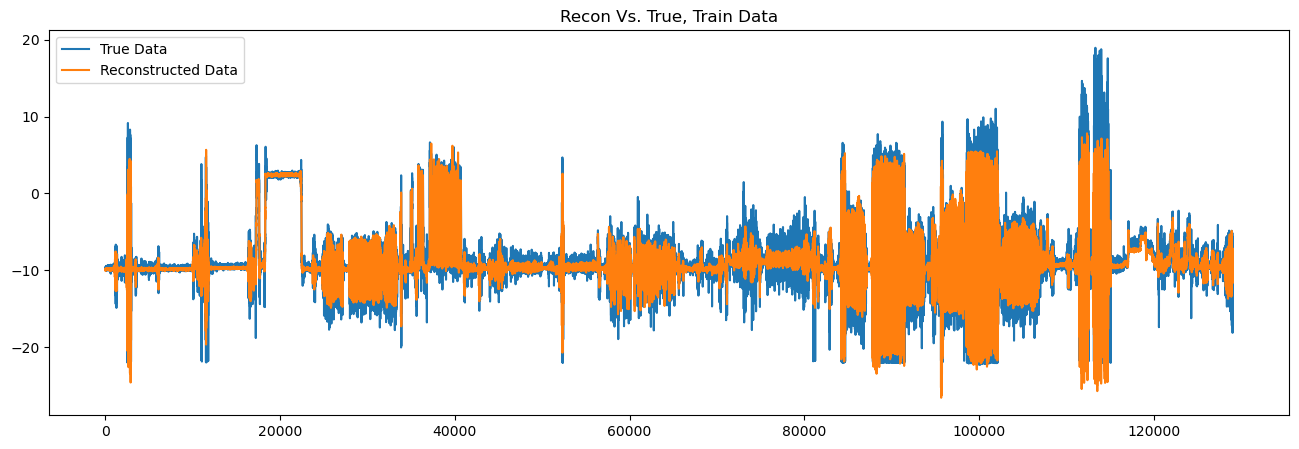

In [47]:
plt.figure(figsize=(16,5))
plt.title("Recon Vs. True, Train Data")
plt.plot(dataset[:split_idx], label="True Data")
plt.plot(reconstruction.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Train Data")
plt.legend()

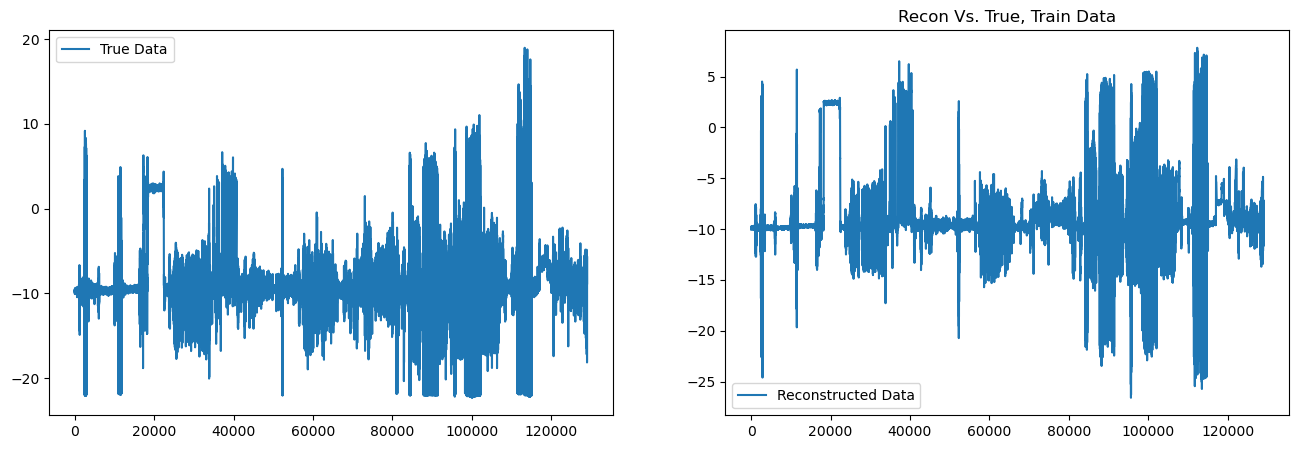

In [49]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(dataset[:split_idx], label="True Data")
plt.legend()
plt.subplot(1,2,2)
plt.plot(reconstruction.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Train Data")
plt.legend()

C:\Users\Admin\AppData\Local\Temp\ipykernel_35552\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


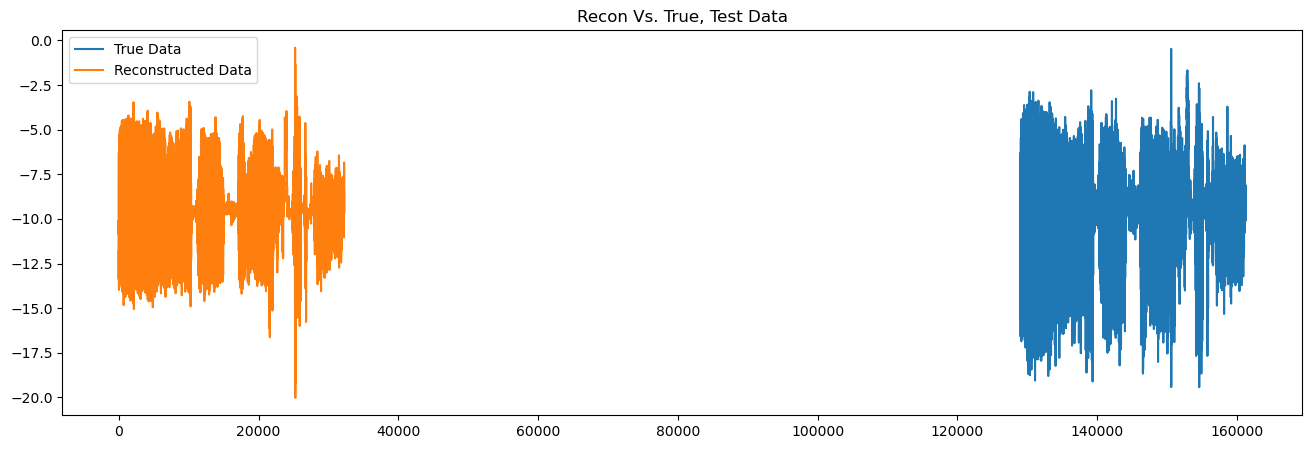

In [50]:
test_recon = predict(model, test_loader)

plt.figure(figsize=(16,5))
plt.plot(dataset[split_idx:], label="True Data")
plt.plot(test_recon.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Test Data")
plt.legend()

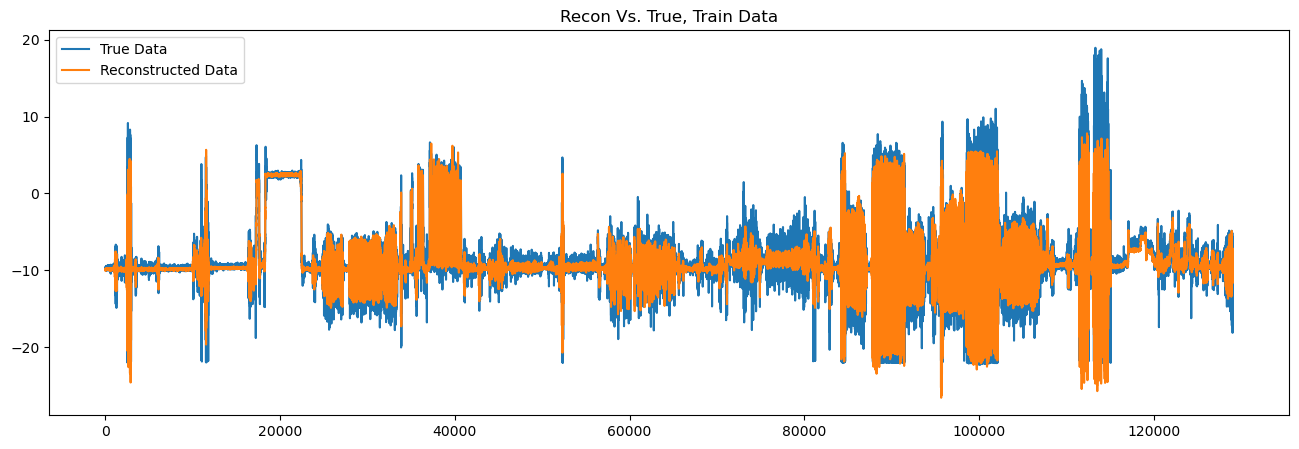

In [51]:
# plt.subplots(2)
plt.figure(figsize=(16,5))
plt.plot(dataset[:split_idx], label="True Data")
plt.plot(reconstruction.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Train Data")
plt.legend()

In [52]:
subject_2 = pd.read_csv('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject2.csv')
sub_2_split_idx = int(len(subject_2) * 0.8)
subject_2 = subject_2['chest acceleration X-axis']

subject_2

0        -9.8646
1        -9.7753
2        -9.6195
3        -9.7610
4        -9.8078
           ...  
130556   -9.4231
130557   -9.5361
130558   -9.4680
130559   -9.6448
130560   -9.0025
Name: chest acceleration X-axis, Length: 130561, dtype: float64

In [53]:
# training dataset
sub_2_train = mHealth(
    dataframe=subject_2[:split_idx],
)

sub_2_test = mHealth(
    dataframe=subject_2[split_idx:],
)

sub_2_whole = mHealth(
    dataframe=subject_2,
)

sub_2_train_loader = torch.utils.data.DataLoader(
    dataset=sub_2_train,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

sub_2_test_loader = torch.utils.data.DataLoader(
    dataset=sub_2_test,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

sub_2_whole_loader = torch.utils.data.DataLoader(
    dataset=sub_2_whole,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

In [54]:
# sub_2_recon = predict(model, sub_2_whole_loader)

In [55]:
# # plt.subplots(2)
# plt.figure(figsize=(16,5))
# plt.plot(subject_2, label="True Data")
# plt.plot(sub_2_recon.cpu(), label="Reconstructed Data")
# plt.title("Recon Vs. True, Train Data")
# plt.legend()

In [56]:
# subject_3 = pd.read_csv('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject3.csv')
# sub_3_split_idx = int(len(subject_3) * 0.8)
# subject_3 = subject_3['chest acceleration X-axis']

# # training dataset
# sub_3_train = mHealth(
#     dataframe=subject_3[:split_idx],
# )

# sub_3_test = mHealth(
#     dataframe=subject_3[split_idx:],
# )

# sub_3_whole = mHealth(
#     dataframe=subject_3,
# )

# sub_3_train_loader = torch.utils.data.DataLoader(
#     dataset=sub_3_train,
#     batch_size=batch_size,
#     collate_fn=collate_fn,
#     shuffle=False,
#     drop_last=True
# )

# sub_3_test_loader = torch.utils.data.DataLoader(
#     dataset=sub_3_test,
#     batch_size=batch_size,
#     collate_fn=collate_fn,
#     shuffle=False,
#     drop_last=True
# )

# sub_3_whole_loader = torch.utils.data.DataLoader(
#     dataset=sub_3_whole,
#     batch_size=batch_size,
#     collate_fn=collate_fn,
#     shuffle=False,
#     drop_last=True
# )

# sub_3_recon = predict(model, sub_3_whole_loader)

# # plt.subplots(2)
# plt.figure(figsize=(16,5))
# plt.plot(subject_3, label="True Data")
# plt.plot(sub_3_recon.cpu(), label="Reconstructed Data")
# plt.title("Recon Vs. True")
# plt.legend()

In [57]:
def plot_predictions(model):
    for i in range(10):

        path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject' + str(i+1) + '.csv'
        df = pd.read_csv(path)
        
        df = df['chest acceleration X-axis']
        
        df = df.to_numpy().reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(-10, 10))

        df = scaler.fit_transform(df)
        df = pd.Series(df.squeeze())
        
        dataset = mHealth(
            dataframe=df,
        )
        
        dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=512,
            collate_fn=collate_fn,
            shuffle=False,
            drop_last=True
        )
        
        reconstructed_data = predict(model, dataloader)
        
        plt.figure(figsize=(16,5))
        plt.plot(df, label="True Data")
        plt.plot(reconstructed_data.cpu(), label="Reconstructed Data")
        plt.title("Recon Vs. True, Whole Dataset")
        plt.legend()
                

C:\Users\Admin\AppData\Local\Temp\ipykernel_35552\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]
C:\Users\Admin\AppData\Local\Temp\ipykernel_35552\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


KeyboardInterrupt: 

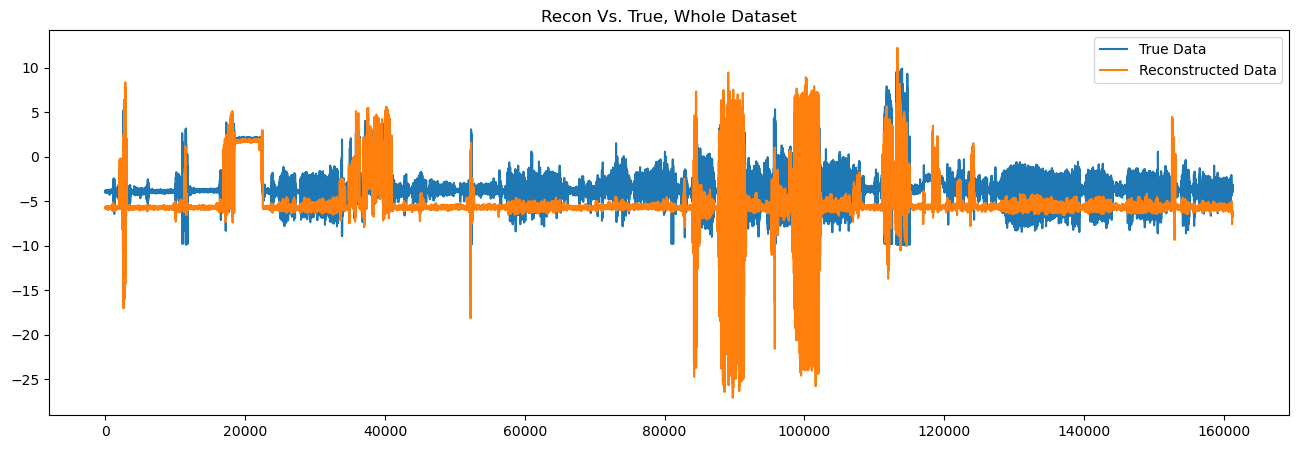

In [58]:
plot_predictions(model)

In [31]:
from sklearn.preprocessing import MinMaxScaler

def plot_predictions_daphnet(model):
    # for i in range(10):

    # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\Daphnet_CSV\\S01R01.csv'
    path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\Daphnet_CSV\\S08R01.csv'
    # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\smartphone activity detection\\train.csv'
    # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MobiAct_Dataset_v2.0\\Annotated Data\\BSC\\BSC_1_1_annotated.csv'
    # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\UPFallCompleteDataSet.csv'
    
    df = pd.read_csv(path)
    # df = df['tBodyAcc-mean()-X']
    # df = df['acc_x']
    # df = df['BeltAccelerometer']
    df = df['trunk acceleration lateral']
    # df = df['trunk acceleration forward']
    
    # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\Daphnet_CSV\\S01R01.csv'
    # df = pd.read_csv(path)
    
    # df = df['trunk acceleration lateral']
    
    df = df.to_numpy().reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-10, 10))

    df = scaler.fit_transform(df)
    df = pd.Series(df.squeeze())
    
    dataset = mHealth(
        dataframe=df,
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=512,
        collate_fn=collate_fn,
        shuffle=False,
        drop_last=True
    )
    
    reconstructed_data = predict(model, dataloader)
    
    fig, axs = plt.subplots(3, 1, figsize=(15, 10))  # 3 rows, 1 column
    axs[0].plot(df, label="True Data")
    axs[0].plot(reconstructed_data.cpu(), label="Reconstructed Data")
    axs[0].set_title("Recon Vs. True, Daphnet")
    axs[0].legend()
    
    axs[1].plot(df, label="True Data")
    axs[1].set_title("True Daphnet")
    axs[1].legend()
    
    axs[2].plot(reconstructed_data.cpu(), label="Reconstructed Data", color='orange')
    axs[2].set_title("Recon Daphnet")
    axs[2].legend()
    
    plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_35552\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


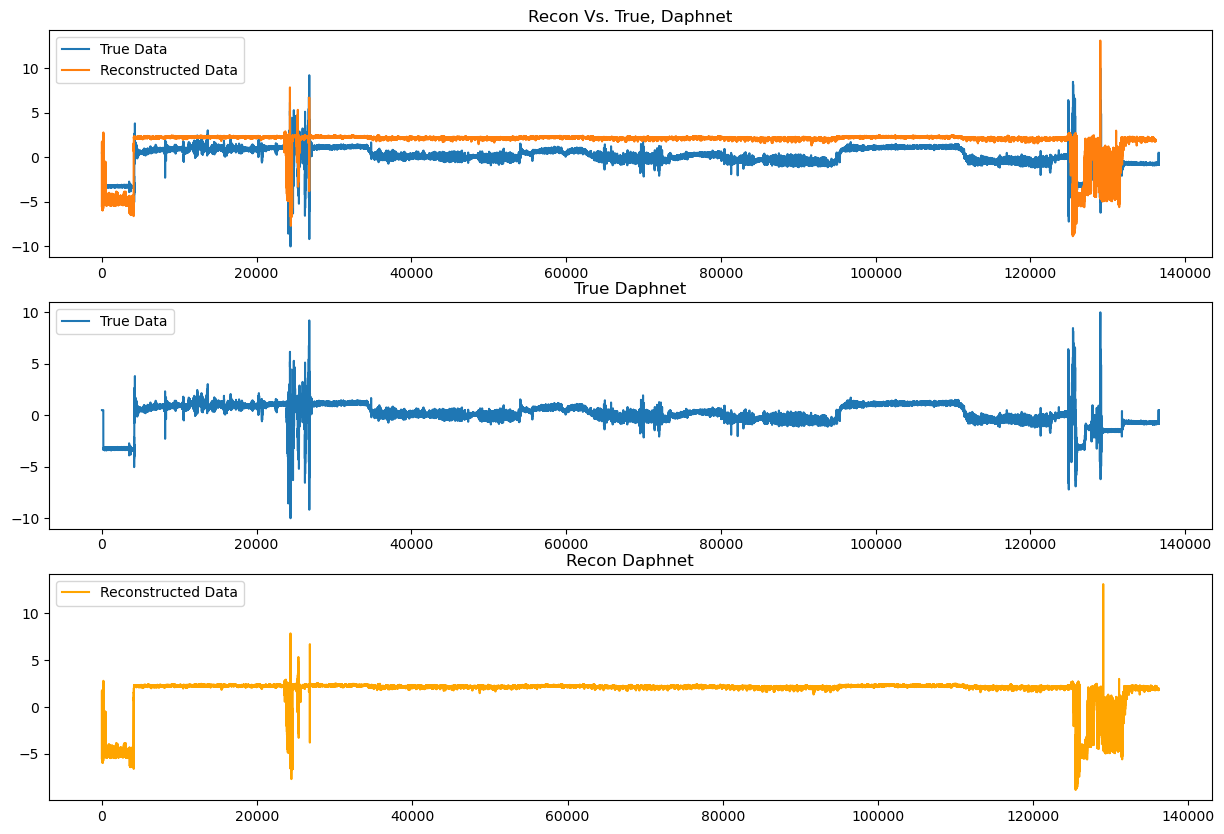

In [32]:
plot_predictions_daphnet(model)

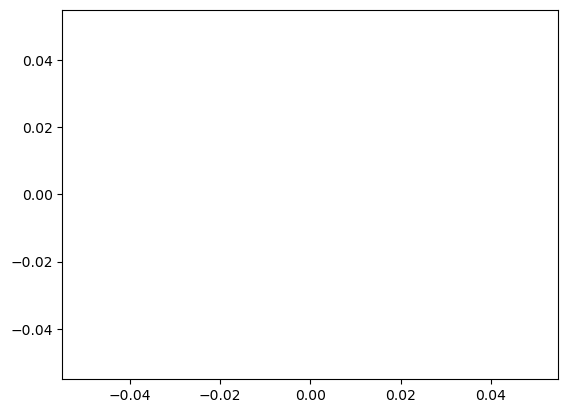

In [ ]:
plt.plot(train_loss)
plt.plot(test_loss)

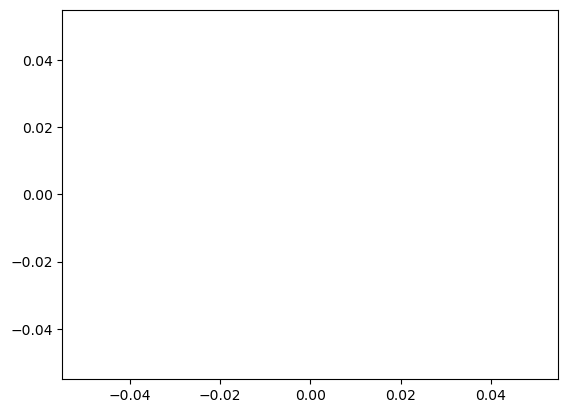

In [ ]:
plt.plot(learning_rate)

In [ ]:
# cwd = os.getcwd() + "/MHEALTHDATASET_CSV"
if(platform.system() == 'Windows'):
    cwd = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV'
else:
    cwd = '/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV'

print(cwd)

os.chdir(cwd)

#split data into sections by label

df = pd.DataFrame()
dataframes = []
for file in os.listdir():
    if file.endswith(".csv"):
        file_path = f"{cwd}/{file}"
        temp = pd.read_csv(file_path)
        dataframes.append(temp)
        print('file:', file, '| size = ', len(temp))
        
df = pd.concat(dataframes)

C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTHDATASET_CSV
file: mHealth_subject1.csv | size =  161280
file: mHealth_subject10.csv | size =  98304
file: mHealth_subject2.csv | size =  130561
file: mHealth_subject3.csv | size =  122112
file: mHealth_subject4.csv | size =  116736
file: mHealth_subject5.csv | size =  119808
file: mHealth_subject6.csv | size =  98304
file: mHealth_subject7.csv | size =  104448
file: mHealth_subject8.csv | size =  129024
file: mHealth_subject9.csv | size =  135168


In [ ]:
#extracts x,y,z chest accel data into different label groups
def partition_data(label, dataframe):
    x_data = []
    y_data = []
    z_data = []
    activity = []
    
    for i in range(len(dataframe)):
        if(df['label'].iloc[i] == label):
            x_data.append(df['chest acceleration X-axis'].iloc[i])
            y_data.append(df['chest acceleration Y-axis'].iloc[i])
            z_data.append(df['chest acceleration Z-axis'].iloc[i])
            activity.append(df['label'].iloc[i])
            
    
    partitioned_df = pd.DataFrame(
                                  {
        'x-axis': x_data,
        'y-axis': y_data,
        'z-axis': z_data,
        'label': activity
                                  })
    
    return partitioned_df

In [ ]:
#splitting all mhealth data based on label, used for classification
df_null = partition_data(0, df)
df_stand = partition_data(1, df) 
df_sit = partition_data(2, df)
df_lying = partition_data(3, df)
df_walk = partition_data(4, df)
df_stairs = partition_data(5, df)
df_waist_bend = partition_data(6, df)
df_arms = partition_data(7, df) 
df_knee_bend = partition_data(8, df) 
df_cycle = partition_data(9, df) 
df_jog = partition_data(10, df) 
df_run = partition_data(11, df) 
df_jump = partition_data(12, df) 

KeyboardInterrupt: 

In [ ]:
class classifier_dataset(torch.utils.data.Dataset):

    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): dataframe containing data
        """
        self.dataset = dataframe['x-axis']
        # print(self.dataset)
        self.labels = dataframe['label']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index
        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 in (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        # sequence = torch.tensor(self.dataset[index*128:index*128+128].to_numpy()).type(torch.float32) 
        sequence = torch.tensor(self.dataset[index:index+128].to_numpy()).type(torch.float32) 
        # print(sequence)
        sequence = sequence.unsqueeze(dim=1) #remove when using 3 dim, currently needed for 1 dim data
        
        # print("seq shape: ", sequence.shape)
        label = torch.tensor(self.labels.iloc[index])
        # print("lavel shape;", label.shape)
        # print(label)
        return sequence, label

#pad sequences that aren't 128 length with 0's
def collate_fn(data):
    labels = []
    for d in data:
        labels.append(torch.tensor(d[1]))
    
    labels = torch.tensor(labels)
    inputs = [torch.tensor(d[0]) for d in data]
    inputs = pad_sequence(inputs, batch_first=True)
    
    # print("data[0][1], ", data[0][1])

    return inputs, labels

In [ ]:
len(df_jump)//128

80

In [ ]:
split_idx = int(len(df_jump) * 0.8)

class_train = classifier_dataset(
    dataframe=df_jump[:split_idx]
)

class_test = classifier_dataset(
    dataframe=df_jump[split_idx:]
)

class_train_loader = torch.utils.data.DataLoader(
    class_train, 
    batch_size=8, 
    shuffle=True, 
    drop_last=True,
    collate_fn=collate_fn
    )

class_test_loader = torch.utils.data.DataLoader(
    class_test, 
    batch_size=8, 
    shuffle=True, 
    drop_last=True,
    collate_fn=collate_fn
    )

In [ ]:
class Classifier(nn.Module):

  def __init__(self, input_dim=128, num_classes=13, num_units=8, dropout=0.5, hidden=True):
    super(Classifier, self).__init__()
    self.fcin = nn.Linear(input_dim, num_units)
    self.fchidden = nn.Linear(num_units, num_units)
    self.fcout = nn.Linear(num_units, num_classes)
    self.dropout = nn.Dropout(dropout)
    self.act = torch.nn.ReLU()
    self.h = hidden


  def forward(self, x):
    # print('x in shape: ', x.shape)
    x = self.act(self.fcin(x))
    if self.h:
      x = self.act(self.fchidden(x))
    x = self.dropout(x)
    x = self.fcout(x)
    # print("x out shape: ", x.shape)
    return x
    
classifier = Classifier().to(device)
class_train_loss = []
class_test_loss = []

In [ ]:
learning_rate = 0.01
num_epochs = 200
i = 0

criterion = nn.CrossEntropyLoss()  # Since it's a classification task
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    
    model.train()
    running_train_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(class_train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        encoded, _ = model.reconstruct(inputs)
        # print("encoded shape: ", encoded.shape)
        encoded = encoded[0, :, :]
        
        
        
        # Forward pass
        outputs = classifier(encoded).to(device)
        
        # assert outputs.shape[0] == 13, f"Output shape mismatch: {outputs.shape}"
        # assert targets.shape[0] == 4, f"Target shape mismatch: {targets.shape}"
        
        # print(outputs.shape)
        # print(targets.shape)
        # print(type(targets))
       
        y_pred = torch.round(torch.sigmoid(outputs))
        loss = criterion(outputs, targets.type(torch.LongTensor).to(device))
        
        running_train_loss += loss.item() * inputs.size(0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    running_test_loss = 0.0
    
    epoch_train_loss = running_train_loss / len(class_train_loader)
    class_train_loss.append(float(epoch_train_loss))

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(class_test_loader):
            
            encoded, _ = model.reconstruct(inputs)
            encoded = encoded[0, :, :]
            outputs = classifier(encoded).to(device)
            
            loss = criterion(outputs, targets.type(torch.LongTensor).to(device))
            running_test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted.to(device) == targets.to(device)).sum().item()
    
    epoch_test_loss = running_test_loss / len(class_test_loader)
    class_test_loss.append(epoch_test_loss)
    val_accuracy = correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

C:\Users\Admin\AppData\Local\Temp\ipykernel_33868\4178157600.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_33868\4178157600.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Epoch [1/200], Loss: 2.5218
Epoch [2/200], Loss: 1.4316
Epoch [3/200], Loss: 1.2344
Epoch [4/200], Loss: 2.1894
Epoch [5/200], Loss: 1.7886
Epoch [6/200], Loss: 1.7604
Epoch [7/200], Loss: 2.4456
Epoch [8/200], Loss: 1.7758
Epoch [9/200], Loss: 1.6485
Epoch [10/200], Loss: 1.8102
Epoch [11/200], Loss: 2.0644
Epoch [12/200], Loss: 2.0208
Epoch [13/200], Loss: 2.3728
Epoch [14/200], Loss: 1.9522
Epoch [15/200], Loss: 2.0717
Epoch [16/200], Loss: 1.8260
Epoch [17/200], Loss: 2.0280
Epoch [18/200], Loss: 2.3065
Epoch [19/200], Loss: 1.7305
Epoch [20/200], Loss: 1.9394


KeyboardInterrupt: 

In [ ]:
temp = df_jump['x-axis'].iloc[:128].to_numpy()
temp = torch.tensor(temp).type(torch.float32)
temp = temp.unsqueeze(dim=0)
temp = temp.unsqueeze(dim=2)
print(temp.shape)
type(temp)

torch.Size([1, 128, 1])


torch.Tensor

In [ ]:
encoded = model.encode(temp)

In [ ]:
print(encoded.shape)

torch.Size([2, 1, 128])


In [ ]:
encoded, decoded = model.reconstruct(temp)

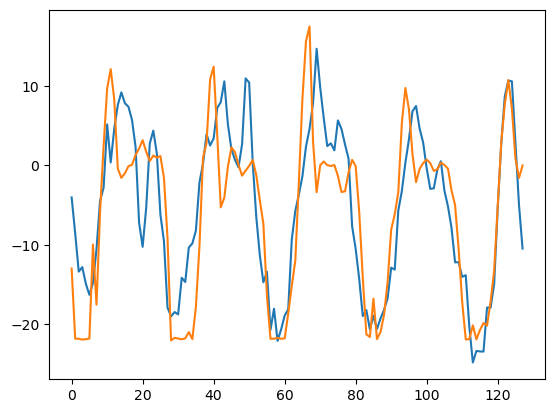

In [ ]:
plt.plot(decoded.detach().cpu().numpy())
plt.plot(df_jump['x-axis'].iloc[:128].to_numpy())

In [ ]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    Classifier,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss()

)

In [ ]:
type(df_jump['x-axis'][0])

numpy.float64

In [ ]:
from sklearn.model_selection import GridSearchCV


# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)
params = {
    'lr': [0.001, 0.001],
    'max_epochs': [10, 20, 50],
    'module__num_units': [32, 64],
    'module__dropout': [0.1],
    'module__input_dim': [2],
    'module__num_classes': [13],
    'module__hidden': [True, False]

}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=0)

gs.fit(df_jump['x-axis'].to_numpy(),df_jump['label'].to_numpy())
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

ValueError: 
All the 72 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1319, in fit
    self.partial_fit(X, y, **fit_params)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1278, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1190, in fit_loop
    self.run_single_epoch(iterator_train, training=True, prefix="train",
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1226, in run_single_epoch
    step = step_fn(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1105, in train_step
    self._step_optimizer(step_fn)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1060, in _step_optimizer
    optimizer.step(step_fn)
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\optim\optimizer.py", line 391, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\optim\optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\optim\adam.py", line 148, in step
    loss = closure()
           ^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1094, in step_fn
    step = self.train_step_single(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 993, in train_step_single
    y_pred = self.infer(Xi, **fit_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1521, in infer
    return self.module_(x, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_33868\1354783692.py", line 14, in forward
    x = self.act(self.fcin(x))
                 ^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\linear.py", line 116, in forward
    return F.linear(input, self.weight, self.bias)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float


In [ ]:
def classifier_train()